In [2]:
%matplotlib inline
import cPickle as pkl
import pandas as pd
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
dataset = pkl.load(open('dataset.pkl', 'rb'))

In [111]:
bots = [u for u in dataset.keys() if "-bot" == str(u)[-4:]]

In [117]:
from hmmlearn import hmm

In [200]:
hmmdata = [dataset[u] for u in dataset.keys() if "bot" not in str(u)]

In [201]:
hmmdata = [h for h in hmmdata if 150 > len(h) and len(h) > 30]

In [202]:
from random import sample
sample_size = 3000
hmmdata = sample(hmmdata, sample_size)

In [122]:
lens = [len(h) for h in hmmdata]

In [123]:
hmmdata = [[h for h in x] for x in hmmdata]

In [124]:
X = np.concatenate(hmmdata)

In [125]:
set(list(X))

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27}

In [126]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
n_components = 4
model = hmm.MultinomialHMM(n_components=n_components, n_iter=40, algorithm='viterbi')

In [128]:
model.fit(np.atleast_2d(X).T,lens)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=4,
        n_iter=40, params='ste',
        random_state=<mtrand.RandomState object at 0x105dd0fa0>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [16]:
label_encodings = ['MemberEvent_same',
 'PublicEvent_same',
 'PullRequestReviewCommentEvent_same',
 'ForkEvent_same',
 'GollumEvent_same',
 'ReleaseEvent_same',
 'PullRequestEvent_same',
 'IssueCommentEvent_same',
 'PushEvent_same',
 'DeleteEvent_same',
 'CommitCommentEvent_same',
 'WatchEvent_same',
 'IssuesEvent_same',
 'CreateEvent_same',
 'MemberEvent_diff',
 'PublicEvent_diff',
 'PullRequestReviewCommentEvent_diff',
 'ForkEvent_diff',
 'GollumEvent_diff',
 'ReleaseEvent_diff',
 'PullRequestEvent_diff',
 'IssueCommentEvent_diff',
 'PushEvent_diff',
 'DeleteEvent_diff',
 'CommitCommentEvent_diff',
 'WatchEvent_diff',
 'IssuesEvent_diff',
 'CreateEvent_diff']

In [129]:
model.score(np.atleast_2d(X).T)

-156019.73691586079

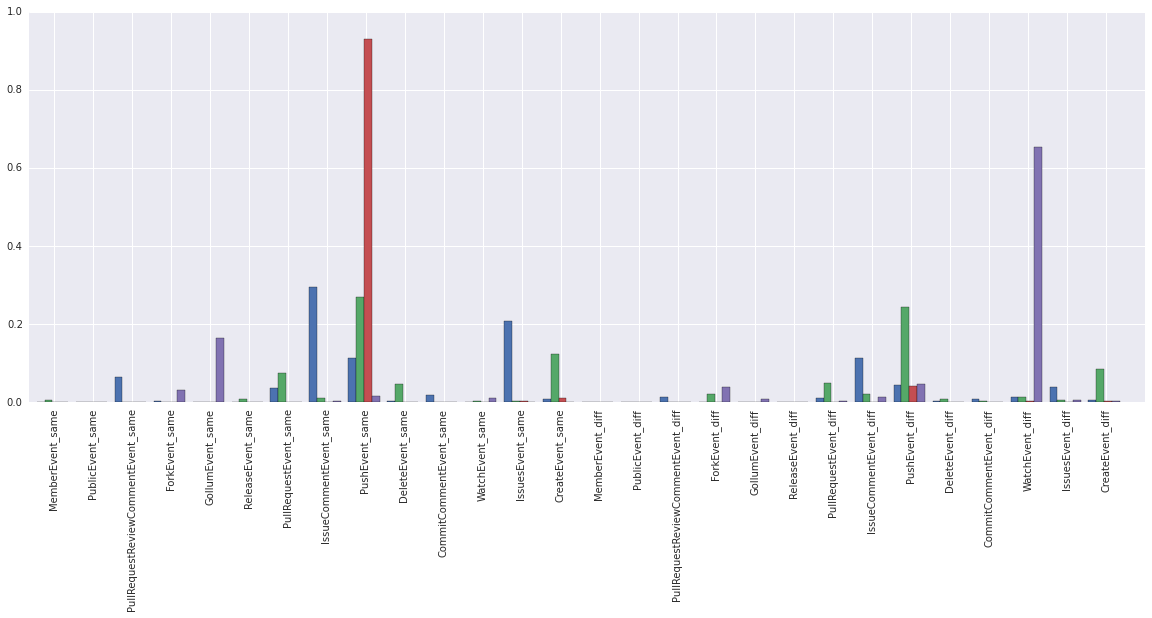

In [130]:
xcoords = np.arange(28)
plt.figure(figsize=(20,7))
ax = plt.subplot(111)
xcoord = .3
colors = sns.color_palette()
for n in range(n_components):
    ax.bar(xcoords - xcoord + n*1./(n_components+1), model.emissionprob_[n], width = 1./(n_components+1), color=colors[n])
ax.set_xticklabels(label_encodings, rotation='vertical')

plt.xlim([-.5,28])
plt.xticks(np.arange(0,29)+.15)

plt.show()


In [131]:
from sklearn.externals import joblib
joblib.dump(model, 'cluster_model.pkl')

['cluster_model.pkl']

In [132]:
hidden_states = model.predict(np.atleast_2d(X).T)

In [133]:
i = 0
states_split = []
for l in lens:
    states_split.append([hidden_states[i:i+l]])
    i += l
states_split= [l[0] for l in states_split]

In [134]:
from collections import Counter
state_props = []
for u in states_split:
    c = Counter(u)
    sp = [float(c[i])/sum(c.values()) for i in range(n_components)]
    state_props.append(sp)

In [136]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
tsne = model.fit_transform(state_props)


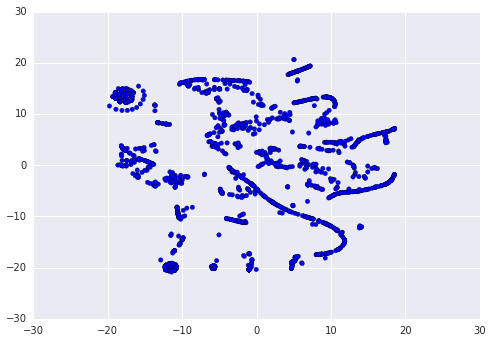

In [137]:
plt.scatter(*zip(*tsne))


In [150]:
ball_ind = [i for (i,t) in enumerate(tsne) if -20 < t[0]< -15 and 10 < t[1] < 17]

In [151]:
ball_data = [hmmdata[i] for i in ball_ind]

In [180]:
ball_counter = Counter(sum(ball_data, []))
ball_tuples = []
for k in range(len(label_encodings)):
    ball_tuples.append((k,ball_counter[k]))
ball_freqs = [float(b)/sum(ball_counter.values()) for (a,b) in ball_tuples]

all_counter = Counter(sum(hmmdata, []))
all_tuples = []
for k in range(len(label_encodings)):
    all_tuples.append((k,all_counter[k]))
all_freqs = [float(b)/sum(all_counter.values()) for (a,b) in all_tuples]

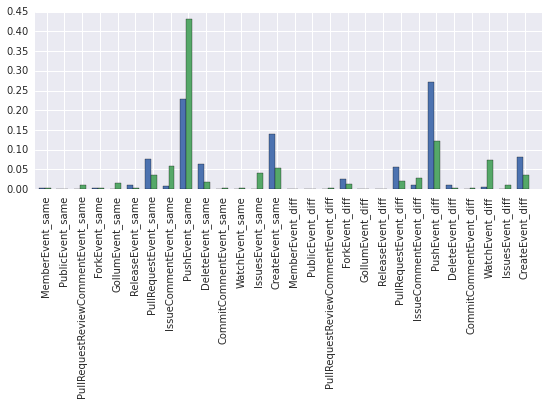

In [181]:
plot_data = [ball_freqs, all_freqs]
xcoords = np.arange(28)
plt.figure(figsize=(20,7))
ax = plt.subplot(222)
xcoord = .3
colors = sns.color_palette()
for n in range(2):
    ax.bar(xcoords - xcoord + n*1./(2+1), plot_data[n], width = 1./(2+1), color=colors[n])
ax.set_xticklabels(label_encodings, rotation='vertical')

plt.xlim([-.5,28])
plt.xticks(np.arange(0,29)+.15)

plt.show()

In [188]:
output_freqs = []
for u in hmmdata:
    u_counter = Counter(u)
    u_tuple = []
    for k in range(len(label_encodings)):
        u_tuple.append((k,u_counter[k]))
    u_freqs = [float(b)/sum(u_counter.values()) for (a,b) in u_tuple]
    output_freqs.append(u_freqs)

In [198]:
from sklearn.decomposition import PCA
model_output = PCA(n_components=2)
pca_output = model_output.fit_transform(output_freqs)

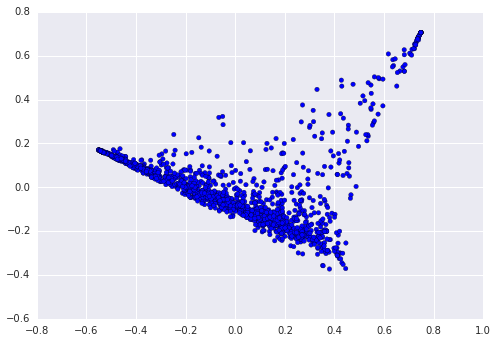

In [199]:
plt.scatter(*zip(*pca_output))
